## 德州扑克

探索一下德州扑克中的数字。

In [1]:
try:
    import google.colab
    import sys
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB and sys.version.startswith('3.8'):
    #install python 3.9
    !sudo apt-get update -y
    !sudo apt-get install python3.9

    #change alternatives
    !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 1
    !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 2

    #check python version
    !python --version
    #3.9.16

    # install pip for new python 
    !sudo apt-get install python3.9-distutils
    !wget https://bootstrap.pypa.io/get-pip.py
    !python get-pip.py

    # credit of these last two commands blongs to @Erik
    # install colab's dependencies
    !python -m pip install ipython ipython_genutils ipykernel jupyter_console prompt_toolkit httplib2 astor

    # link to the old google package
    !ln -s /usr/local/lib/python3.8/dist-packages/google \
        /usr/local/lib/python3.9/dist-packages/google

    print(f"现在重启colab，就可以使用python3.9了")

In [2]:
# 你可能需要安装这些依赖包
!pip install numpy treys matplotlib tqdm ipywidgets

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [3]:
import math
import re

import numpy as np
from treys.card import Card
from treys.evaluator import Evaluator
from treys.deck import Deck
from tqdm import trange

from simulator import Simulator
from plot import flip_matrix, plot_card_rate

In [4]:
suits = [
    {
        "name": "spade",
        "symbol": "♠",
        "color": "black",
        "short": "s",
        "cn_name": "黑桃",
    },
    {
        "name": "heart",
        "symbol": "♥",
        "color": "red",
        "short": "h",
        "cn_name": "红桃",
    },
    {
        "name": "club",
        "symbol": "♣",
        "color": "black",
        "short": "c",
        "cn_name": "梅花",
    },
    {
        "name": "diamond",
        "symbol": "♦",
        "color": "red",
        "short": "d",
        "cn_name": "方块",
    },
]
n_suits = len(suits)
print(f"德州扑克中的花色共有{n_suits}种，分别是：")
for suit in suits:
    print(f"- {suit['symbol']} {suit['cn_name']} ({suit['name']})")

ranks = [
    {"name": "ace", "symbol": "A"},
    {"name": "king", "symbol": "K"},
    {"name": "queen", "symbol": "Q"},
    {"name": "jack", "symbol": "J"},
    {"name": "ten", "symbol": "10"},
    {"name": "nine", "symbol": "9"},
    {"name": "eight", "symbol": "8"},
    {"name": "seven", "symbol": "7"},
    {"name": "six", "symbol": "6"},
    {"name": "five", "symbol": "5"},
    {"name": "four", "symbol": "4"},
    {"name": "three", "symbol": "3"},
    {"name": "two", "symbol": "2"},
]
n_rank = len(ranks)
print()
print(f"德州扑克中的牌面共有{n_rank}种，分别是：")
for rank in ranks:
    print(f"{rank['symbol']}" + " ", end="")
print()

n_cards = n_suits * n_rank
print()
print(f"德州扑克中的扑克牌共有{n_cards}张.")

德州扑克中的花色共有4种，分别是：
- ♠ 黑桃 (spade)
- ♥ 红桃 (heart)
- ♣ 梅花 (club)
- ♦ 方块 (diamond)

德州扑克中的牌面共有13种，分别是：
A K Q J 10 9 8 7 6 5 4 3 2 

德州扑克中的扑克牌共有52张.


## 起手牌

开局每个人都会发到两张牌，这两张牌叫做起手牌。在轮到我们行动的时候，我们一般在看牌之后选择：
* 弃牌：放弃这一局
* 加注：加注，然后轮到下一个人行动
* 跟注：跟注，然后轮到下一个人行动

这时候的决策是基于我们的起手牌好坏，以及其他人的行动。这里我们先不考虑其他人的行动，只考虑我们的起手牌好坏。


### 一对一

我们可以通过模拟来估算不同起手牌的胜率，从最简单的一对一开始。

In [5]:
n_comb = math.comb(n_cards, 2)
print(f"起手牌的组合共有{n_comb}种。")

起手牌的组合共有1326种。


In [6]:
records = Simulator(suits="shdc", ranks="23456789TJQKA", n_players=2).run(
    n=1000000, progress_bar=True
)


100%|██████████████████████████████| 1000000/1000000 [00:59<00:00, 16695.60it/s]


In [7]:
def pair2index(pair):
    """以(num1, num2)形式返回手牌，如果是同花色，则按照从小到大的顺序，否则按照从大到小的顺序"""
    assert len(pair) == 2
    nums = [Card.get_rank_int(x) for x in sorted(pair)]
    suited = Card.get_suit_int(pair[0]) == Card.get_suit_int(pair[1])
    return tuple(nums if suited else nums[::-1])


In [8]:
# 每一种起手牌赢的计数
win_count = np.zeros((n_rank, n_rank))
# 每一种起手牌的总计数
total_count = np.zeros((n_rank, n_rank))

for record in records:
    top_rank = min(record["ranks"])
    for hand, rank in zip(record["hands"], record["ranks"]):
        hand_index = pair2index(hand)
        if rank == top_rank:
            # 如果是最好的手牌，则计数加1，对角线上下用于区分是否同色，同色的在右上方
            win_count[hand_index] += 1
        # 总计数加1
        total_count[hand_index] += 1

# 计算每一种起手牌的胜率
win_rate = win_count / total_count


将两人桌起手牌胜率画成热力图


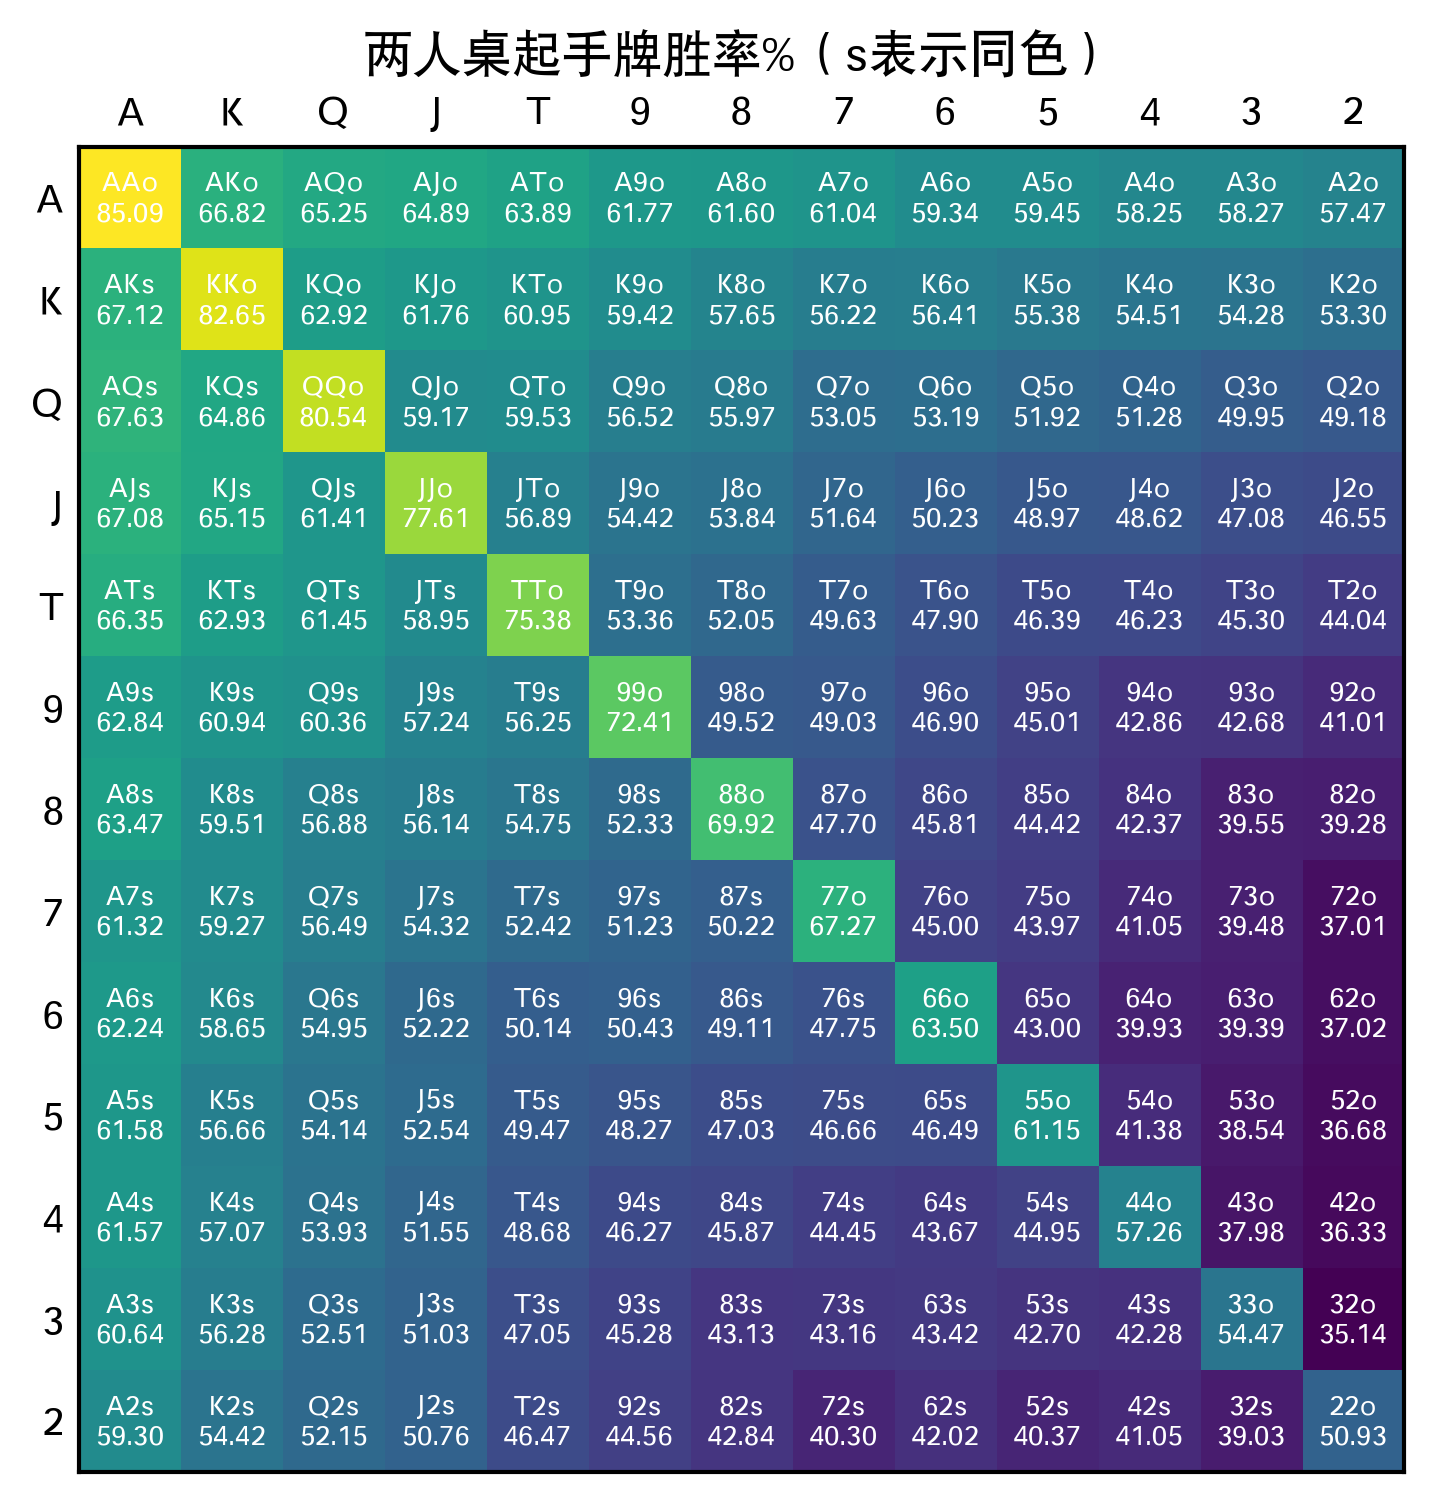

In [9]:
win_rate_flip = flip_matrix(win_rate)
print(f"将两人桌起手牌胜率画成热力图")
plot_card_rate(win_rate_flip, title="两人桌起手牌胜率%（s表示同色）", path_to_save="win_rate_2p.pdf")

## 皇家同花顺

在皇家扑克玩法里，只包含四种花色10-A的大牌。我们希望在这个牌局里拿到皇家同花顺，并且尽可能少输，求最优策略。

首先来计算一下不同起手牌拿到皇家同花顺的概率。

In [14]:
records = Simulator(ranks="TJQKA", n_players=5).run(n=10000000, progress_bar=True)

100%|█████████████████████████████| 10000000/10000000 [17:30<00:00, 9518.89it/s]


In [15]:
# 每一种起手牌赢的计数
royal_flush_count = np.zeros((n_rank, n_rank))
# 每一种起手牌的总计数
total_count = np.zeros((n_rank, n_rank))

ROYAL_FLUSH_RANK = 1

for record in records:
    for hand, rank in zip(record["hands"], record["ranks"]):
        hand_index = pair2index(hand)
        if rank == ROYAL_FLUSH_RANK:
            # 如果是皇家同花顺，则计数加1
            royal_flush_count[hand_index] += 1
        # 总计数加1
        total_count[hand_index] += 1

# 计算每一种起手牌的皇家同花顺率
royal_flush_rate = royal_flush_count[8:,8:] / total_count[8:, 8:]

In [20]:
print(f"总皇家同花顺率为{royal_flush_rate.sum():.2%}")

总皇家同花顺率为0.56%


将皇家同花顺率画成热力图


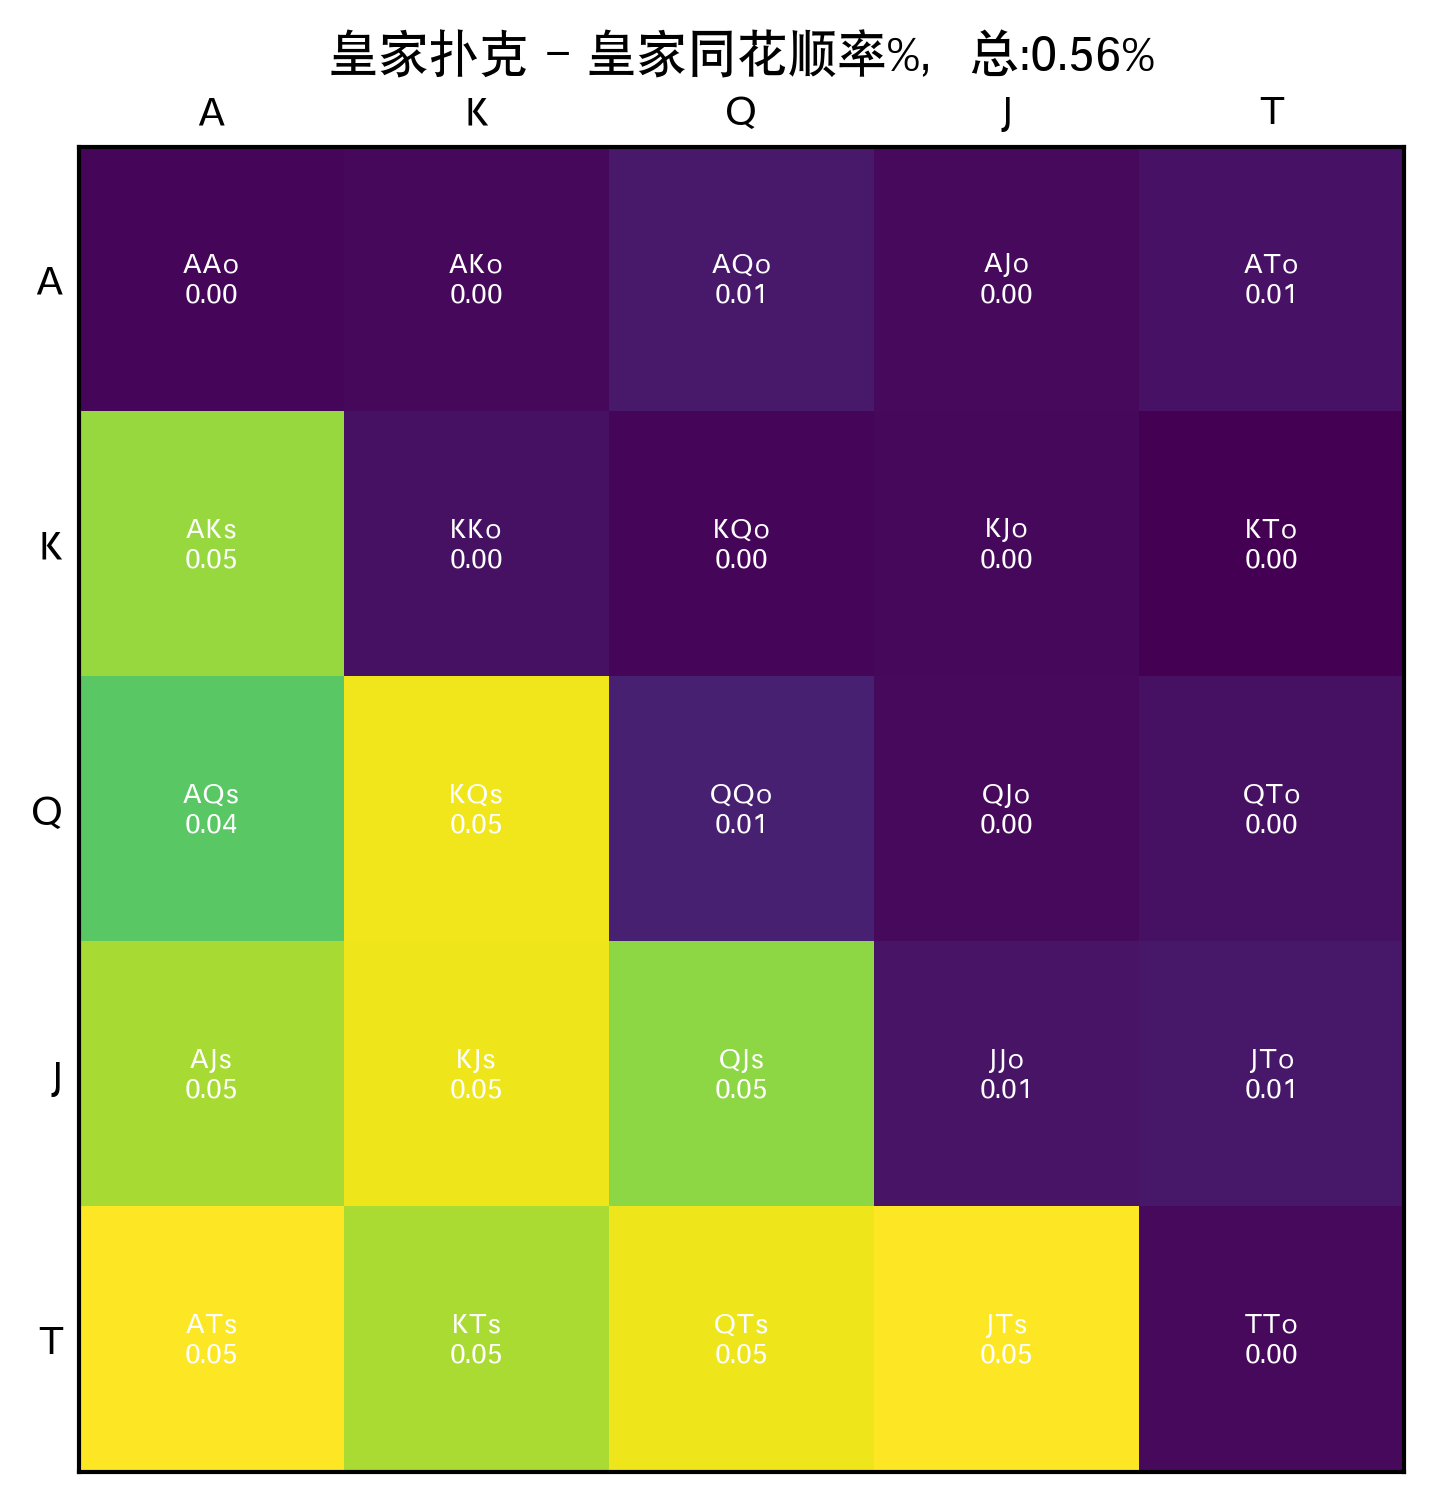

In [25]:
royal_flush_rate_flip = flip_matrix(royal_flush_rate)
print(f"将皇家同花顺率画成热力图")
plot_card_rate(
    royal_flush_rate_flip,
    title=f"皇家扑克 - 皇家同花顺率%，总:{royal_flush_rate.sum():.2%}",
    row_ticks=["A", "K", "Q", "J", "T"],
    col_ticks=["A", "K", "Q", "J", "T"],
    path_to_save="royal_flush_rate.pdf",
)


In [19]:
# 每一种起手牌赢的计数
win_count = np.zeros((n_rank, n_rank))
# 每一种起手牌的总计数
total_count = np.zeros((n_rank, n_rank))

for record in records:
    top_rank = min(record["ranks"])
    for hand, rank in zip(record["hands"], record["ranks"]):
        hand_index = pair2index(hand)
        if rank == top_rank:
            # 如果是最好的手牌，则计数加1，对角线上下用于区分是否同色，同色的在右上方
            win_count[hand_index] += 1
        # 总计数加1
        total_count[hand_index] += 1

# 计算每一种起手牌的胜率
win_rate = win_count[8:,8:] / total_count[8:, 8:]

将两人桌起手牌胜率画成热力图


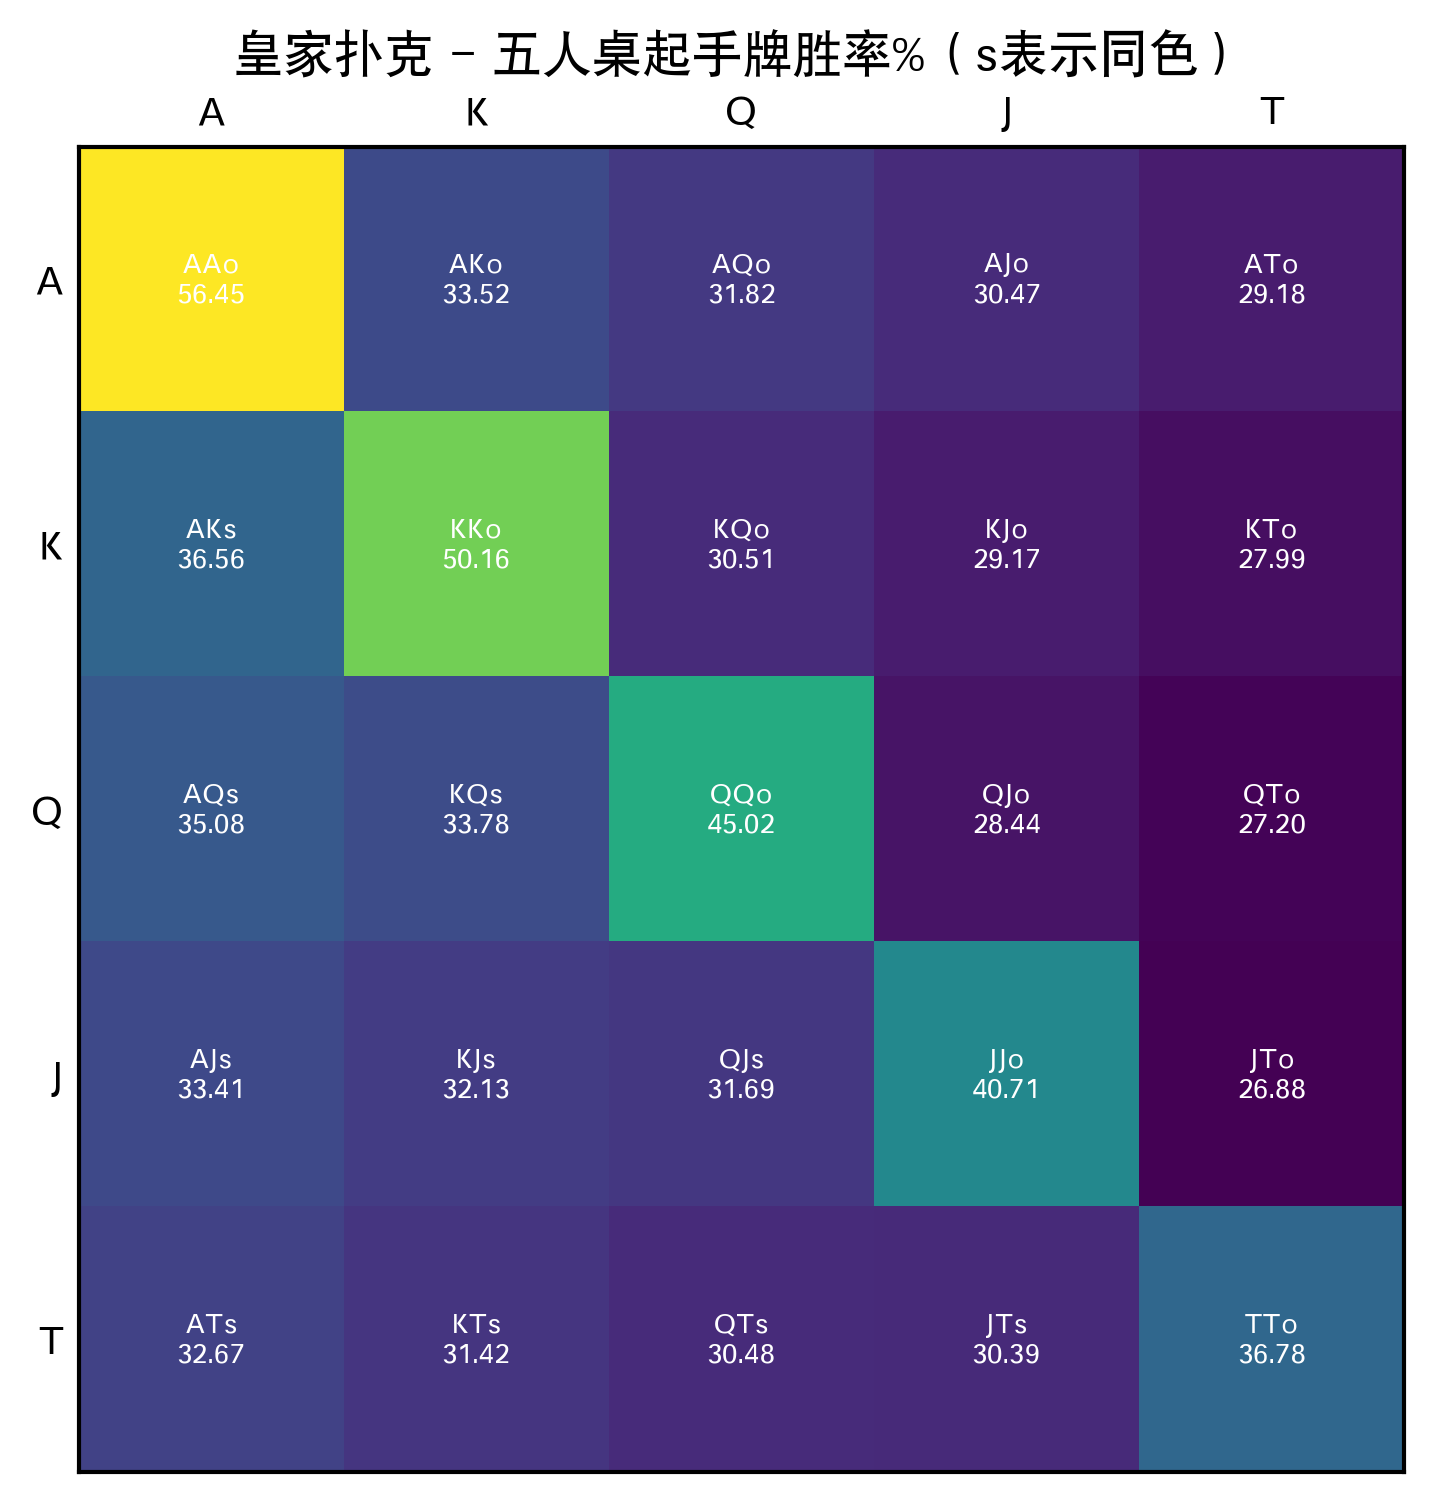

In [28]:
win_rate_flip = flip_matrix(win_rate)
print(f"将两人桌起手牌胜率画成热力图")
plot_card_rate(
    win_rate_flip, title="皇家扑克 - 五人桌起手牌胜率%（s表示同色）",
    row_ticks=["A", "K", "Q", "J", "T"],
    col_ticks=["A", "K", "Q", "J", "T"],
    path_to_save="win_rate_2p.pdf"
)
